## Importing all required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #For getting output of multiple expressions in single code cell
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## Cleaning and Filtering the data

In [2]:
products = pd.read_csv('/ratings_Beauty.csv')  #Dataset having columns like UserId,ProductId,Ratings of product
products = products.dropna() #removes rows containing NULL values
products.drop(['Timestamp'], axis=1,inplace=True)
products.head()
products.shape

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0


(1261036, 3)

## Total Unique Users and Products

In [3]:
print("Total data ")
print("-"*30)
print("Total no of ratings :",products.shape[0])
print("Total no of Users :", len(np.unique(products.UserId)))
print("Total no of products :", len(np.unique(products.ProductId)))

Total data 
------------------------------
Total no of ratings : 1261036
Total no of Users : 851180
Total no of products : 122597


## Analyzing the rating

In [4]:
#Highest no of ratings given by user

no_of_ratings_per_user = products.groupby(by='UserId')['Rating'].count().sort_values(ascending=False)

no_of_ratings_per_user.head()

UserId
A3M174IC0VXOS2    293
A281NPSIMI1C2R    262
A3KEZLJ59C1JVH    251
A1RRMZKOMZ2M7J    208
A2V5R832QCSOMX    203
Name: Rating, dtype: int64

## Popularity Based Recommendation

In [5]:
#Making the new dataframe which contains users who has given 70 or more ratings

new_df=products.groupby("ProductId").filter(lambda x:x['Rating'].count() >=70)
len(new_df)

520015

In [6]:
# Highest rating of product

new_df.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head()

ProductId
B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
Name: Rating, dtype: int64

In [7]:
avg_rating = new_df.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head()

cnt_rating = new_df.groupby('ProductId').count()['Rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_rating':avg_rating, 'Rating_count':cnt_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='Average_rating',ascending=False)

final_rating.head()

,Average_rating,Rating_count
ProductId,,
B002YFN49I,4.948980,98
B00408QTOY,4.907895,76
B0045W2TDA,4.895833,96
B000YT5NIG,4.873684,95
B000G686X6,4.871429,70


In [8]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['Rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('Average_rating',ascending=False)

    return recommendations.index[:n]

In [9]:
#Recommending top 10 products with 60 minimum interactions based on popularity
print("Top 10 products with 60 minimum interactions based on popularity are ")
list(top_n_products(final_rating, 10, 60))

Top 10 products with 60 minimum interactions based on popularity are 


['B002YFN49I',
 'B00408QTOY',
 'B0045W2TDA',
 'B000YT5NIG',
 'B000G686X6',
 '9790790961',
 'B00004TMFE',
 'B00004TUBL',
 'B00004TUBV',
 'B00004U9UY']

<Axes: xlabel='ProductId'>

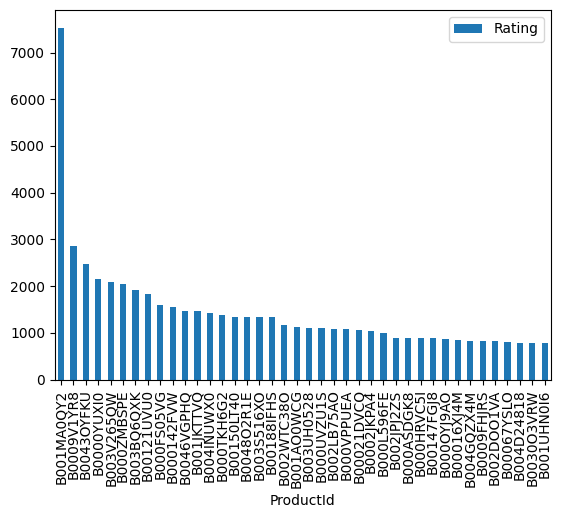

In [10]:
# Barplot of ratings of popular product
popular_products = pd.DataFrame(new_df.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(40).plot(kind = "bar")

Text(0.5, 1.0, 'Ratings per Product')

Text(0.5, 0, 'No of Products')

Text(0, 0.5, 'No of ratings per product')

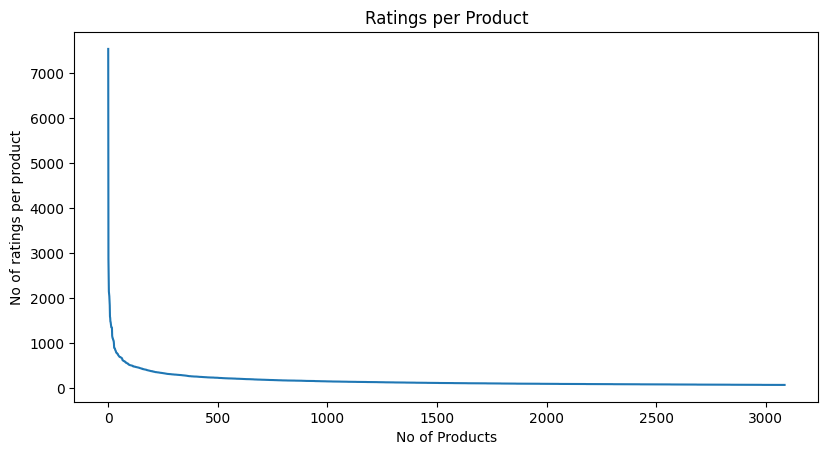

In [11]:
# Ratings per product vs no of products

no_of_ratings_per_product = new_df.groupby(by='ProductId')['Rating'].count().sort_values(ascending=False)

graph = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('Ratings per Product')
plt.xlabel('No of Products')
plt.ylabel('No of ratings per product')

plt.show()

# Collaborative Filtering System

## User-based collaborative filtering

In [12]:
# Create user-item interaction matrix
new_df1 = new_df.head(40000)
ratings_matrix =new_df1.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
ratings_matrix.head()


ProductId,9790790961,B00004TMFE,B00004TUBL,B00004TUBV,B00004U9UY,B00004U9V2,B000050B6U,B000052WYD,B000052WYN,B000052XW5,...,B000196U04,B0001AGMWE,B0001APV44,B0001B86HM,B0001DDJZO,B0001EKTZQ,B0001EKWPI,B0001EL658,B0001EL9AK,B0001M7D7A
UserId,,,,,,,,,,,,,,,,,,,,,
A0143622X8ZC66HZXLUP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01437583CZ7V02UKZQ5S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01456542S5QPYUEGJXR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01907982I6OHXDYN5HD6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02693342D4WEEY3LWSZ9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
ratings_matrix['user_index'] = np.arange(0, ratings_matrix.shape[0])
ratings_matrix.set_index(['user_index'], inplace=True)

ratings_matrix.head()

ProductId,9790790961,B00004TMFE,B00004TUBL,B00004TUBV,B00004U9UY,B00004U9V2,B000050B6U,B000052WYD,B000052WYN,B000052XW5,...,B000196U04,B0001AGMWE,B0001APV44,B0001B86HM,B0001DDJZO,B0001EKTZQ,B0001EKWPI,B0001EL658,B0001EL9AK,B0001M7D7A
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Function to find Similar users and their similarity scores

In [14]:
# Function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(interactions_matrix.shape[0]):

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity]
    similarity_score = [tup[1] for tup in similarity]

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [15]:
#Finding out top 10 similar users to the user index 3
similarUsers = similar_users(5,ratings_matrix)[0][0:10]
print("Top 10 similar users to the user index 3 are")
similarUsers


Top 10 similar users to the user index 3 are


[46, 81, 98, 101, 104, 180, 201, 282, 513, 517]

## Function to recommend products

In [16]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

In [17]:
# Recommend 5 products to user index 3 based on similarity based collaborative filtering
print("5 products recommended to user index 3 based on user similarity are ")
recommendations(3,5,ratings_matrix)

5 products recommended to user index 3 based on user similarity are 


['B00005O0MZ', 'B0000YUXI0', 'B00008O2X5', 'B000141YHI', 'B00005B9FV']

## Model-based collaborative filtering system

In [18]:
# Rating Matrix
ratings_matrix.head()
len(ratings_matrix)

ProductId,9790790961,B00004TMFE,B00004TUBL,B00004TUBV,B00004U9UY,B00004U9V2,B000050B6U,B000052WYD,B000052WYN,B000052XW5,...,B000196U04,B0001AGMWE,B0001APV44,B0001B86HM,B0001DDJZO,B0001EKTZQ,B0001EKWPI,B0001EL658,B0001EL9AK,B0001M7D7A
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


38295

In [19]:
ratings_matrix.shape

(38295, 203)

In [20]:
transpose_matrix = ratings_matrix.T
transpose_matrix.shape

(203, 38295)

In [21]:
temp = transpose_matrix

### Decomposing the Matrix using SVD Technique

In [22]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(transpose_matrix)
decomposed_matrix.shape

(203, 10)

In [23]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(203, 203)

## Function to recommend products using existing user-item interactions to predict the top items that a user might like the most.

In [57]:
def product_recommendation(product_index):
  i = transpose_matrix.index[product_index]
  product_names = list(transpose_matrix.index)
  product_ID = product_names.index(i)
  correlation_product_ID = correlation_matrix[product_ID]

  #Recommend only those elements that have a correlation value greater than 0.70
  Recommend = list(transpose_matrix.index[correlation_product_ID > 0.70])

  # Removes the item already bought by the customer
  Recommend.remove(i)
  return Recommend[0:10]

In [60]:
print("Top 10 products that a user might like the most are ")
product_recommendation(55)

Top 10 products that a user might like the most are 


['9790790961',
 'B000052WYN',
 'B000052YP6',
 'B000052ZTY',
 'B0000534VO',
 'B0000535CH',
 'B000056KK0',
 'B00005O0MZ',
 'B00006FDU6',
 'B00007M0CP']

## Evaluating the model

In [29]:
average_rating = ratings_matrix.mean()
average_rating.head()

ProductId
9790790961    0.007808
B00004TMFE    0.012325
B00004TUBL    0.067528
B00004TUBV    0.019063
B00004U9UY    0.018018
dtype: float64

In [43]:
ratings_sparse = csr_matrix(ratings_matrix.values)
# Singular Value Decomposition
U, s, Vt = svds(ratings_sparse, k = 50)    # k is the number of latent features

sigma = np.diag(s)

In [44]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = ratings_matrix.columns)
preds_df.head()
preds_matrix = preds_df.values

ProductId,9790790961,B00004TMFE,B00004TUBL,B00004TUBV,B00004U9UY,B00004U9V2,B000050B6U,B000052WYD,B000052WYN,B000052XW5,...,B000196U04,B0001AGMWE,B0001APV44,B0001B86HM,B0001DDJZO,B0001EKTZQ,B0001EKWPI,B0001EL658,B0001EL9AK,B0001M7D7A
0,1.935170e-09,8.114029e-08,1.010098e-08,5.255667e-07,1.473352e-06,3.615537e-07,0.000012,6.061302e-07,5.619029e-09,7.998106e-08,...,4.725750e-08,5.885779e-08,8.834017e-08,4.927775e-07,1.116924e-08,5.301112e-11,0.000001,3.419888e-07,7.205717e-19,2.459522e-18
1,1.515947e-09,5.330174e-06,3.820322e-05,1.646609e-05,4.227826e-04,2.207258e-04,0.000126,2.917774e-05,4.485359e-05,3.343480e-04,...,2.253642e-06,1.342256e-06,4.609449e-07,2.371022e-07,4.220558e-07,4.214436e-06,0.003922,3.125371e-04,9.439871e-17,4.806167e-17
2,3.381082e-06,1.071760e-05,1.391414e-06,1.018556e-07,4.435765e-05,3.571261e-07,0.000042,1.229529e-05,1.398376e-08,6.681223e-05,...,1.305170e-06,1.188049e-05,1.117266e-07,2.141460e-08,3.456766e-03,3.567397e-07,0.000036,1.316046e-04,2.410147e-16,1.013809e-15
3,8.173189e-12,6.010121e-09,1.028531e-08,9.242292e-09,6.158890e-08,2.226250e-08,0.000018,7.727517e-08,1.799039e-09,4.637253e-08,...,2.824566e-08,7.536785e-08,1.251656e-07,1.988535e-08,2.179673e-09,2.708233e-07,0.000001,5.928927e-07,1.071232e-18,3.795535e-18
4,6.604453e-09,4.364483e-06,2.762427e-06,1.601963e-06,9.829587e-05,9.754851e-05,0.000102,9.719042e-05,7.836135e-05,1.006495e-04,...,7.610382e-06,1.203542e-06,2.675677e-07,8.146427e-05,8.294677e-07,1.739187e-07,0.001711,3.306443e-03,1.234140e-18,3.859901e-17


In [37]:
avg_preds=preds_df.mean()
avg_preds.head()

ProductId
9790790961    0.000185
B00004TMFE    0.000266
B00004TUBL    0.067927
B00004TUBV    0.001212
B00004U9UY    0.003732
dtype: float64

In [38]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head(10)

,Avg_actual_ratings,Avg_predicted_ratings
ProductId,,
9790790961,0.007808,0.000185
B00004TMFE,0.012325,0.000266
B00004TUBL,0.067528,0.067927
B00004TUBV,0.019063,0.001212
B00004U9UY,0.018018,0.003732
B00004U9V2,0.011438,0.001429
B000050B6U,0.041102,0.042201
B000052WYD,0.014467,0.001748
B000052WYN,0.010941,0.000304


In [39]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.010640547785324755 

